In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:2


In [2]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [3]:
loss_thresh = 25000
level = "_medium"
label = "ES_tanh" + level
ES_val = 200.0

x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

# bound_pts_1 = (X == 0).reshape(-1,)
# bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
# bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
# bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

# xy_bound_1 = xy[bound_pts_1,:]
# xy_bound_2 = xy[bound_pts_2,:]
# xy_bound_3 = xy[bound_pts_3,:]
# xy_bound_4 = xy[bound_pts_4,:]

# u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
# u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
# u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
# u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

# xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
# u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

# xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [4]:
fea_data = scipy.io.loadmat('./../ES_FEA' + level + '.mat')

xy = np.array(fea_data['xy'])
u_true = np.array(fea_data['u'])

xy_test_tensor = torch.from_numpy(xy).float().to(device)
u_true_norm = np.linalg.norm(u_true,2)

In [5]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    N_t = int(N_T/4)
    
    x_BC1 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC1 = np.zeros((N_t,1))
    u_BC1 = 0*np.ones((N_t,1))
    
    x_BC2 = np.ones((N_t,1))
    y_BC2 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC2 = ES_val*np.ones((N_t,1))
    
    x_BC3 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC3 = np.ones((N_t,1)) 
    u_BC3 = 0*np.ones((N_t,1))
    
    x_BC4 = np.zeros((N_t,1))
    y_BC4 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC4 = ES_val*np.ones((N_t,1))
    
    XY_corners = np.array([[0,0],[1,0],[0,1],[1,1]]).reshape(-1,2)
    U_corners = ES_val*np.ones((4,1))
    
    XY_1 = np.hstack((x_BC1,y_BC1))
    XY_2 = np.hstack((x_BC2,y_BC2))
    XY_3 = np.hstack((x_BC3,y_BC3))
    XY_4 = np.hstack((x_BC4,y_BC4))
    
    xy_BC = np.vstack((XY_1,XY_2,XY_3,XY_4,XY_corners)) #choose indices from  set 'idx' (x,t)
    u_BC = np.vstack((u_BC1,u_BC2,u_BC3,u_BC4,U_corners))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        

            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = 2.0*(xy - lbxy)/(ubxy - lbxy) - 1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a =self.activation(z)
       
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
         
    'test neural network'
    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        
        return test_mse, test_re 

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)

    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_step(xy_BC,u_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,u_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [9]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    

    for i in range(max_iter):
        train_step(xy_BC,u_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,u_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [10]:
max_reps = 10
max_iter = 200 #200

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))



N_T = 5000 #Total number of data points for 'y'
N_f = 10000 #Total number of collocation points 


for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
 
    
    torch.manual_seed(reps*36)
    
    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-08, 
                              tolerance_change = 1e-08, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



   
    
    nan_flag = train_model(max_iter,reps)
    
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time



    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

ES_tanh_medium
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 9999.993 Test MSE 3003.2232925017456 Test RE 0.4796111329933651
1 Train Loss 9999.993 Test MSE 3003.2226348173244 Test RE 0.4796110804776583
2 Train Loss 9999.993 Test MSE 3003.2226348173244 Test RE 0.4796110804776583
3 Train Loss 9999.993 Test MSE 3003.2226348173244 Te

In [11]:
u_pred = PINN.test()

ValueError: cannot reshape array of size 1541 into shape (500,500)

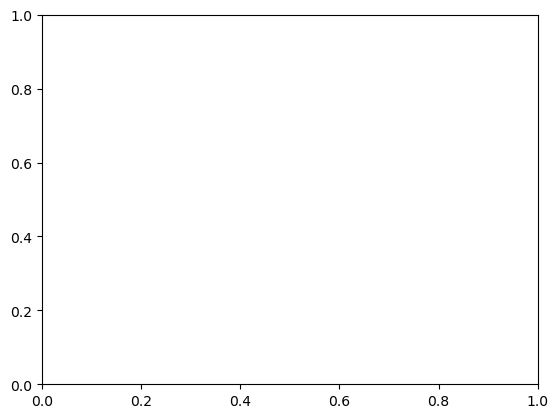

In [12]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(u_pred.reshape(500,500)),vmin = 0,vmax = 500,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)